## IMPORTS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn import linear_model
from sklearn import ensemble
from sklearn import tree
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import root_mean_squared_error

## SETUP

In [2]:
PATH_TRAIN = 'datasets/train.csv'
PATH_TEST = 'datasets/test.csv'

## FUNÇÕES

In [3]:
# Filtra colunas por tipos de dados informados por parâmetro
def obter_lista_de_colunas_por_tipo(dataframe: pd.DataFrame, tipo='nuber') -> list:
    return dataframe.select_dtypes(include=[tipo]).columns

In [4]:
def obter_colunas_com_nulos(dataframe: pd.DataFrame) -> list:
    return dataframe.columns[dataframe.isnull().any()].tolist()

In [5]:
def obter_conj_treinamento_e_teste_estratificado(df: pd.DataFrame, categoria:str):
    
    strat_train_set = None
    strat_valid_set = None

    split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
    for train_index, valid_index in split.split(df, df[categoria]):
        strat_train_set = df.loc[train_index]
        strat_valid_set = df.loc[valid_index]
        
    return strat_train_set, strat_valid_set

In [6]:
def get_dataframe(path: str) -> pd.DataFrame:
    dataframe = pd.read_csv(path)
    return dataframe

## ANÁLISE PRÉVIA DOS DADOS

### Informações gerais

In [7]:
df_train = get_dataframe(path=PATH_TRAIN)
todos_atributos_numericos = obter_lista_de_colunas_por_tipo(df_train, tipo='number')
todos_atributos_categoricos = obter_lista_de_colunas_por_tipo(df_train, tipo='object')

In [8]:
todos_atributos_numericos

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

visualizando as colunas que possuem valores nulos

In [9]:
atributos_numericos_com_valores_numericos_nulos = obter_colunas_com_nulos(df_train[todos_atributos_categoricos])
atributos_numericos_com_valores_numericos_nulos

['Alley',
 'MasVnrType',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

visualizando o percentual de valores nulos

In [10]:
((df_train[atributos_numericos_com_valores_numericos_nulos].isnull().sum() / df_train.shape[0]) * 100).round(2)

Alley           93.77
MasVnrType      59.73
BsmtQual         2.53
BsmtCond         2.53
BsmtExposure     2.60
BsmtFinType1     2.53
BsmtFinType2     2.60
Electrical       0.07
FireplaceQu     47.26
GarageType       5.55
GarageFinish     5.55
GarageQual       5.55
GarageCond       5.55
PoolQC          99.52
Fence           80.75
MiscFeature     96.30
dtype: float64

Verificando os atributos numéricos que possuem maior correlação com o valor de venda e apresentando apenas aqueles que serão utilizados em um primeiro momento.

In [11]:
atributos_corr_top_5 = (df_train[todos_atributos_numericos].corr()['SalePrice']).sort_values(ascending=False)[:6]
atributos_corr_top_5

SalePrice      1.000000
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
GarageArea     0.623431
TotalBsmtSF    0.613581
Name: SalePrice, dtype: float64

### Analisando o atributo OverallQual

In [12]:
df = df_train[['OverallQual', 'SalePrice']]
df['OverallQual'].value_counts()

OverallQual
5     397
6     374
7     319
8     168
4     116
9      43
3      20
10     18
2       3
1       2
Name: count, dtype: int64

<Axes: xlabel='OverallQual', ylabel='SalePrice'>

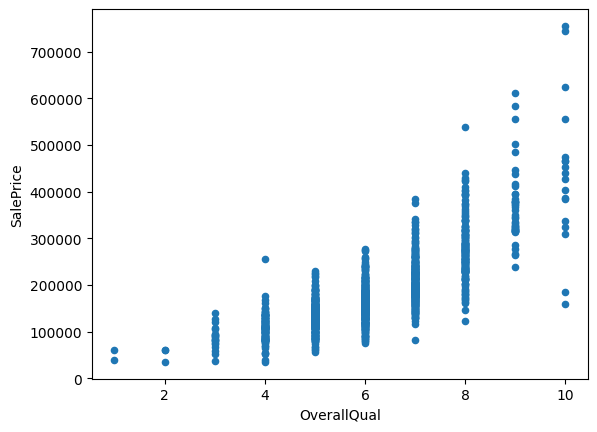

In [13]:
df.plot(kind='scatter', x='OverallQual', y='SalePrice')

Sobre o gráfico de dispersão:

1. Tendência: Positiva
2. Correlação: Forte uma vez que os pontos estão alinhados de forma ascendente. 
3. Distribuição: Há uma variação considerável no SalePrice dentro de uma mesma avaliação
4. Outliers: OverallQual 4, 8, 9 e 10
5. Variabilidade: a uma maior dispersão dos preços em faixas de qualidade mais alta, onde os fatores de diferenciação (como localização, tamanho, idade do imóvel) podem ter um impacto maior.

## TREINANDO E AVALIANDO MODELOS

In [14]:
train_set, valid_set = obter_conj_treinamento_e_teste_estratificado(df, 'OverallQual')

X_train = train_set[['OverallQual']]
y_train = train_set['SalePrice']

X_valid = valid_set[['OverallQual']]
y_valid = valid_set['SalePrice']

test_set = get_dataframe(path=PATH_TEST)

In [15]:
reg_linear = linear_model.LinearRegression()
reg_linear.fit(X_train, y_train)
y_predict = reg_linear.predict(X_valid)
root_mean_squared_error(y_valid, y_predict)

np.float64(59803.628225198845)

In [16]:
decision_tree_reg = tree.DecisionTreeRegressor()
decision_tree_reg.fit(X_train, y_train)
y_predict = decision_tree_reg.predict(X_valid)
root_mean_squared_error(y_valid, y_predict)

np.float64(54620.612522997806)

In [17]:
random_forest_reg = ensemble.RandomForestRegressor()
random_forest_reg.fit(X_train, y_train)
y_predict = random_forest_reg.predict(X_valid)
root_mean_squared_error(y_valid, y_predict)

np.float64(54872.607222309656)

### Gerando o submit

In [18]:
decision_tree_reg.fit(train_set[['OverallQual']], train_set['SalePrice'])
y_predict = decision_tree_reg.predict(test_set[['OverallQual']])

In [23]:
test_set['SalePrice'] = y_predict
df_submit = test_set[['Id', 'SalePrice']]
df_submit.to_csv("sumit.csv", index=False)